# Task 1 : Set up colab gpu runtime environment

In [ ]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 88 kB 2.1 MB/s 
     |████████████████████████████████| 376 kB 16.2 MB/s 
     |████████████████████████████████| 58 kB 7.8 MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-py3-none-any.whl size=12421 sha256=84f5d5d47f5e565a116cd34c590f2d62cf228d01a5c0dd73774ceedf9be90ce4
  Stored in directory: /root/.cache/pip/wheels/90/6b/0c/f0ad36d00310e65390b0d4c9218ae6250ac579c92540c9097a
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60965 sha256=e286a2dbba94adaeafb8f2e1a7daff4cf6e7f5b6aa9a63aa02346d8ca3ee739b
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built efficientnet-pytorch pretrainedmodels
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning htt

# Download Dataset

original author of the dataset :
https://github.com/VikramShenoy97/Human-Segmentation-Dataset


In [ ]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

Cloning into 'Human-Segmentation-Dataset-master'...
remote: Enumerating objects: 592, done.
remote: Counting objects: 100% (592/592), done.
remote: Compressing objects: 100% (591/591), done.
remote: Total 592 (delta 3), reused 587 (delta 1), pack-reused 0
Receiving objects: 100% (592/592), 13.60 MiB | 2.40 MiB/s, done.
Resolving deltas: 100% (3/3), done.


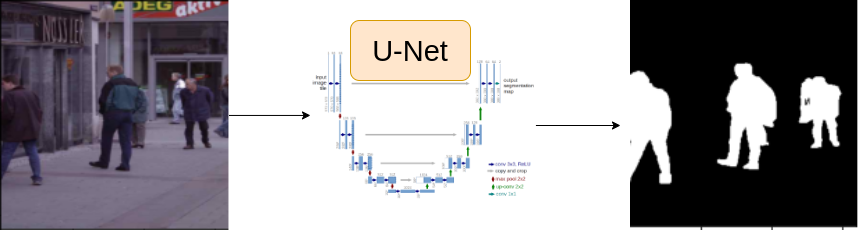

# Some Common Imports

In [ ]:
import sys
sys.path.append('/content/Human-Segmentation-Dataset-master')

In [ ]:
import torch 
import cv2

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

#Setup Configurations

In [ ]:
CSV_FILE = '/content/Human-Segmentation-Dataset-master/train.csv'
DATA_DIR = '/content/'

DEVICE = 'cuda'

EPOCHS = 25
LR = 0.003
IMAGE_SIZE = 320
BATCH_SIZE = 16

ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'

In [ ]:
df = pd.read_csv(CSV_FILE)
df.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [ ]:
row = df.iloc[40]

image_path = row.images
mask_path = row.masks

image = cv2.imread(image_path)
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)/255.0

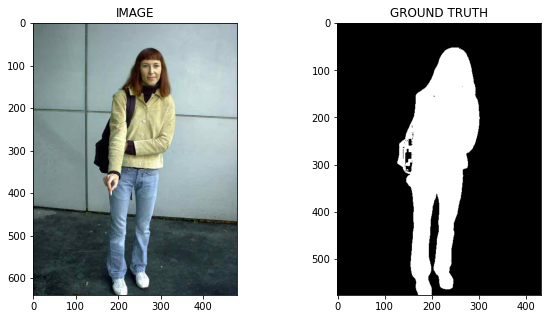

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
        
ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [ ]:
train_df, valid_df = train_test_split(df, test_size = 0.2, random_state = 42)

#Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [ ]:
import albumentations as A

In [ ]:
def get_train_augs():
  return A.Compose([
      A.Resize(IMAGE_SIZE, IMAGE_SIZE),
      A.HorizontalFlip(p=0.5),
      A.VerticalFlip(p=0.5)
  ])

def get_valid_augs():
  return A.Compose([
      A.Resize(IMAGE_SIZE, IMAGE_SIZE)
  ])

#Create Custom Dataset 

In [ ]:
from torch.utils.data import Dataset

In [ ]:
class SegmentationDataset(Dataset):

  def __init__(self, df, augmentations):

    self.df = df
    self.augmentations = augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self,idx):

    row = self.df.iloc[idx]

    image_path = row.images
    mask_path = row.masks

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) #(h,w,c)
    mask = np.expand_dims(mask, axis = -1)

    if self.augmentations:
      data = self.augmentations(image=image, mask=mask)
      image = data['image']
      mask = data['mask']

    #(h,w,c) -> (c,h,w)

    image = np.transpose(image, (2,0,1)).astype(np.float32)
    mask = np.transpose(mask, (2,0,1)).astype(np.float32)

    image = torch.Tensor(image)/255.0
    mask = torch.round(torch.Tensor(mask)/255.0)

    return image, mask



In [ ]:
trainset = SegmentationDataset(train_df, get_train_augs())
validset = SegmentationDataset(valid_df, get_train_augs())

In [ ]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 232
Size of Validset : 58


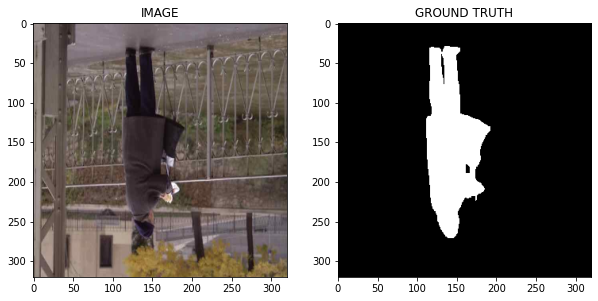

In [ ]:
idx = 4
image, mask = trainset[idx]
helper.show_image(image,mask)


#Load dataset into batches

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
validloader = DataLoader(validset, batch_size=BATCH_SIZE)

In [ ]:
print(f'total no. of batches in trainloader : {len(trainloader)}')
print(f'total no. of batches in validloader : {len(validloader)}')

total no. of batches in trainloader : 15
total no. of batches in validloader : 4


In [ ]:
for image, mask in trainloader:
  break

print(f'One batch image shape : {image.shape}')
print(f'One batch mask shape : {mask.shape}')

One batch image shape : torch.Size([16, 3, 320, 320])
One batch mask shape : torch.Size([16, 1, 320, 320])


#Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [ ]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [ ]:
class SegmentationModel(nn.Module):

  def __init__(self):
    super(SegmentationModel, self).__init__()

    self.arc = smp.Unet(
        encoder_name = ENCODER,
        encoder_weights = WEIGHTS,
        in_channels = 3,
        classes = 1,
        activation = None
    )

  def forward(self, images, masks = None):

    logits = self.arc(images)

    if masks != None:
      loss1 = DiceLoss(mode='binary')(logits, masks)
      loss2 = nn.BCEWithLogitsLoss()(logits, masks)
      return logits, loss1 + loss2
    
    return logits


In [ ]:
model = SegmentationModel()
model.to(DEVICE)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b0_aa-827b6e33.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b0_aa-827b6e33.pth


  0%|          | 0.00/20.4M [00:00<?, ?B/s]

SegmentationModel(
  (arc): Unet(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): Swish()
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (act1): Swish()
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (gate): Sigmoid()
            )
            (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn2): BatchNorm2d(16, eps

#Create Train and Validation Function 

In [ ]:
def train_fn(data_loader, model, optimizer):

  model.train()
  total_loss = 0.0

  for images, masks in tqdm(data_loader):

    images = images.to(DEVICE)
    masks = masks.to(DEVICE)

    optimizer.zero_grad()
    logits, loss = model(images, masks)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()
  
  return total_loss/len(data_loader)

In [ ]:
def eval_fn(data_loader, model):

  model.eval()
  total_loss = 0.0

  with torch.no_grad():
    for images, masks in tqdm(data_loader):

      images = images.to(DEVICE)
      masks = masks.to(DEVICE)

      logits, loss = model(images, masks)

      total_loss += loss.item()
  
    return total_loss/len(data_loader)

# Task 8 : Train Model

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [ ]:
best_valid_loss = np.Inf

for i in range(EPOCHS):

  train_loss = train_fn(trainloader,model,optimizer)
  valid_loss = eval_fn(validloader, model)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), 'best_model.pt')
    print('SAVED MODEL')
    best_valid_loss = valid_loss
  
  print(f'Epoch : {i+1} Train_loss : {train_loss} valid_loss : {valid_loss}')


100%|██████████| 4/4 [00:00<00:00,  4.73it/s]


SAVED MODEL
Epoch : 1 Train_loss : 0.7033498386542002 valid_loss : 2.3386654257774353


100%|██████████| 4/4 [00:00<00:00,  4.78it/s]


SAVED MODEL
Epoch : 2 Train_loss : 0.3594512661298116 valid_loss : 0.5441307127475739


100%|██████████| 4/4 [00:00<00:00,  4.60it/s]


SAVED MODEL
Epoch : 3 Train_loss : 0.32051446040471393 valid_loss : 0.5147578865289688


100%|██████████| 4/4 [00:00<00:00,  4.60it/s]


SAVED MODEL
Epoch : 4 Train_loss : 0.2855453451474508 valid_loss : 0.20473578944802284


100%|██████████| 4/4 [00:00<00:00,  4.72it/s]


Epoch : 5 Train_loss : 0.22084067265192667 valid_loss : 0.20615074038505554


100%|██████████| 4/4 [00:00<00:00,  4.68it/s]


Epoch : 6 Train_loss : 0.21414591272672018 valid_loss : 0.21706350520253181


100%|██████████| 4/4 [00:01<00:00,  4.00it/s]


Epoch : 7 Train_loss : 0.23584269980589548 valid_loss : 0.25681591778993607


100%|██████████| 4/4 [00:00<00:00,  4.64it/s]


Epoch : 8 Train_loss : 0.23735136936108273 valid_loss : 0.22620003670454025


100%|██████████| 4/4 [00:00<00:00,  4.66it/s]


Epoch : 9 Train_loss : 0.21345462103684743 valid_loss : 0.2185477279126644


100%|██████████| 4/4 [00:00<00:00,  4.68it/s]


Epoch : 10 Train_loss : 0.1804413268963496 valid_loss : 0.21140366792678833


100%|██████████| 4/4 [00:00<00:00,  4.72it/s]


Epoch : 11 Train_loss : 0.18789246280988056 valid_loss : 0.25971609726548195


100%|██████████| 4/4 [00:00<00:00,  4.71it/s]


Epoch : 12 Train_loss : 0.17563259998957317 valid_loss : 0.2670121192932129


100%|██████████| 4/4 [00:00<00:00,  4.09it/s]


Epoch : 13 Train_loss : 0.15965612083673478 valid_loss : 0.30010785162448883


100%|██████████| 4/4 [00:00<00:00,  4.69it/s]


Epoch : 14 Train_loss : 0.13907654931147892 valid_loss : 0.2281673178076744


100%|██████████| 4/4 [00:00<00:00,  4.66it/s]


Epoch : 15 Train_loss : 0.13907641222079595 valid_loss : 0.24902620911598206


100%|██████████| 4/4 [00:00<00:00,  4.71it/s]


Epoch : 16 Train_loss : 0.17462572902441026 valid_loss : 0.23210378363728523


100%|██████████| 4/4 [00:00<00:00,  4.65it/s]


Epoch : 17 Train_loss : 0.13662950346867245 valid_loss : 0.21546800062060356


100%|██████████| 4/4 [00:00<00:00,  4.66it/s]


SAVED MODEL
Epoch : 18 Train_loss : 0.143266590933005 valid_loss : 0.1726195588707924


100%|██████████| 4/4 [00:00<00:00,  4.62it/s]


Epoch : 19 Train_loss : 0.14268646637598673 valid_loss : 0.19257988594472408


100%|██████████| 4/4 [00:00<00:00,  4.75it/s]


Epoch : 20 Train_loss : 0.11406315018733343 valid_loss : 0.1881365291774273


100%|██████████| 4/4 [00:00<00:00,  4.68it/s]


Epoch : 21 Train_loss : 0.14038025041421254 valid_loss : 0.21064255386590958


100%|██████████| 4/4 [00:00<00:00,  4.56it/s]


Epoch : 22 Train_loss : 0.13318575620651246 valid_loss : 0.24018915742635727


100%|██████████| 4/4 [00:00<00:00,  4.71it/s]


Epoch : 23 Train_loss : 0.12847215831279754 valid_loss : 0.24514583870768547


100%|██████████| 4/4 [00:00<00:00,  4.69it/s]


Epoch : 24 Train_loss : 0.12438107977310817 valid_loss : 0.17803263291716576


100%|██████████| 4/4 [00:00<00:00,  4.68it/s]

Epoch : 25 Train_loss : 0.12568695644537609 valid_loss : 0.29117026180028915


# Task 9 : Inference

In [ ]:
idx = 5

model.load_state_dict(torch.load('/content/best_model.pt'))

image, mask = validset[idx]

logits_mask = model(image.to(DEVICE).unsqueeze(0)) #(C,H,W) -> (1,C,H,W)
pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask > 0.5)*1.0

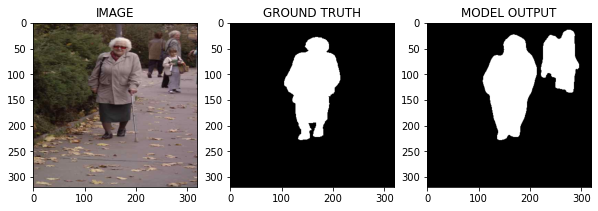

In [ ]:
helper.show_image(image, mask, pred_mask.detach().cpu().squeeze(0))

# For updates about upcoming and current guided projects follow me on...

Twitter : @parth_AI

Linkedin : www.linkedin.com/in/pdhameliya